In [1]:
import json
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
from api_funcs import connectAPI

In [2]:
df_rm = connectAPI("RICKMORTYAPI").get_results_df()
df_rm

connected to https://rickandmortyapi.com/api/character


,id,name,status,species,type,gender,origin,location,image,episode,url,created
0,1,Rick Sanchez,Alive,Human,,Male,"{'name': 'Earth (C-137)', 'url': 'https://rick...","{'name': 'Citadel of Ricks', 'url': 'https://r...",https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht...",https://rickandmortyapi.com/api/character/1,2017-11-04T18:48:46.250Z
1,2,Morty Smith,Alive,Human,,Male,"{'name': 'unknown', 'url': ''}","{'name': 'Citadel of Ricks', 'url': 'https://r...",https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/1, ht...",https://rickandmortyapi.com/api/character/2,2017-11-04T18:50:21.651Z
2,3,Summer Smith,Alive,Human,,Female,"{'name': 'Earth (Replacement Dimension)', 'url...","{'name': 'Earth (Replacement Dimension)', 'url...",https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht...",https://rickandmortyapi.com/api/character/3,2017-11-04T19:09:56.428Z
3,4,Beth Smith,Alive,Human,,Female,"{'name': 'Earth (Replacement Dimension)', 'url...","{'name': 'Earth (Replacement Dimension)', 'url...",https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht...",https://rickandmortyapi.com/api/character/4,2017-11-04T19:22:43.665Z
4,5,Jerry Smith,Alive,Human,,Male,"{'name': 'Earth (Replacement Dimension)', 'url...","{'name': 'Earth (Replacement Dimension)', 'url...",https://rickandmortyapi.com/api/character/avat...,"[https://rickandmortyapi.com/api/episode/6, ht...",https://rickandmortyapi.com/api/character/5,2017-11-04T19:26:56.301Z
...,...,...,...,...,...,...,...,...,...,...,...,...
821,822,Young Jerry,unknown,Human,,Male,"{'name': 'Earth (Unknown dimension)', 'url': '...","{'name': 'Earth (Unknown dimension)', 'url': '...",https://rickandmortyapi.com/api/character/avat...,[https://rickandmortyapi.com/api/episode/51],https://rickandmortyapi.com/api/character/822,2021-11-02T17:18:31.934Z
822,823,Young Beth,unknown,Human,,Female,"{'name': 'Earth (Unknown dimension)', 'url': '...","{'name': 'Earth (Unknown dimension)', 'url': '...",https://rickandmortyapi.com/api/character/avat...,[https://rickandmortyapi.com/api/episode/51],https://rickandmortyapi.com/api/character/823,2021-11-02T17:19:00.951Z
823,824,Young Beth,unknown,Human,,Female,"{'name': 'Earth (Unknown dimension)', 'url': '...","{'name': 'Earth (Unknown dimension)', 'url': '...",https://rickandmortyapi.com/api/character/avat...,[https://rickandmortyapi.com/api/episode/51],https://rickandmortyapi.com/api/character/824,2021-11-02T17:19:47.957Z
824,825,Young Jerry,unknown,Human,,Male,"{'name': 'Earth (Unknown dimension)', 'url': '...","{'name': 'Earth (Unknown dimension)', 'url': '...",https://rickandmortyapi.com/api/character/avat...,[https://rickandmortyapi.com/api/episode/51],https://rickandmortyapi.com/api/character/825,2021-11-02T17:20:14.305Z


In [3]:
df_sw = connectAPI("SWAPI").get_results_df()
df_sw

connected to https://swapi.dev/api/people


,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,films,species,vehicles,starships,created,edited,url
0,Luke Skywalker,172,77,blond,fair,blue,19BBY,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",[],"[https://swapi.dev/api/vehicles/14/, https://s...","[https://swapi.dev/api/starships/12/, https://...",2014-12-09T13:50:51.644000Z,2014-12-20T21:17:56.891000Z,https://swapi.dev/api/people/1/
1,C-3PO,167,75,n/a,gold,yellow,112BBY,n/a,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",[https://swapi.dev/api/species/2/],[],[],2014-12-10T15:10:51.357000Z,2014-12-20T21:17:50.309000Z,https://swapi.dev/api/people/2/
2,R2-D2,96,32,n/a,"white, blue",red,33BBY,n/a,https://swapi.dev/api/planets/8/,"[https://swapi.dev/api/films/1/, https://swapi...",[https://swapi.dev/api/species/2/],[],[],2014-12-10T15:11:50.376000Z,2014-12-20T21:17:50.311000Z,https://swapi.dev/api/people/3/
3,Darth Vader,202,136,none,white,yellow,41.9BBY,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",[],[],[https://swapi.dev/api/starships/13/],2014-12-10T15:18:20.704000Z,2014-12-20T21:17:50.313000Z,https://swapi.dev/api/people/4/
4,Leia Organa,150,49,brown,light,brown,19BBY,female,https://swapi.dev/api/planets/2/,"[https://swapi.dev/api/films/1/, https://swapi...",[],[https://swapi.dev/api/vehicles/30/],[],2014-12-10T15:20:09.791000Z,2014-12-20T21:17:50.315000Z,https://swapi.dev/api/people/5/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Grievous,216,159,none,"brown, white","green, yellow",unknown,male,https://swapi.dev/api/planets/59/,[https://swapi.dev/api/films/6/],[https://swapi.dev/api/species/36/],[https://swapi.dev/api/vehicles/60/],[https://swapi.dev/api/starships/74/],2014-12-20T19:43:53.348000Z,2014-12-20T21:17:50.488000Z,https://swapi.dev/api/people/79/
78,Tarfful,234,136,brown,brown,blue,unknown,male,https://swapi.dev/api/planets/14/,[https://swapi.dev/api/films/6/],[https://swapi.dev/api/species/3/],[],[],2014-12-20T19:46:34.209000Z,2014-12-20T21:17:50.491000Z,https://swapi.dev/api/people/80/
79,Raymus Antilles,188,79,brown,light,brown,unknown,male,https://swapi.dev/api/planets/2/,"[https://swapi.dev/api/films/1/, https://swapi...",[],[],[],2014-12-20T19:49:35.583000Z,2014-12-20T21:17:50.493000Z,https://swapi.dev/api/people/81/
80,Sly Moore,178,48,none,pale,white,unknown,female,https://swapi.dev/api/planets/60/,"[https://swapi.dev/api/films/5/, https://swapi...",[],[],[],2014-12-20T20:18:37.619000Z,2014-12-20T21:17:50.496000Z,https://swapi.dev/api/people/82/


<AxesSubplot: >

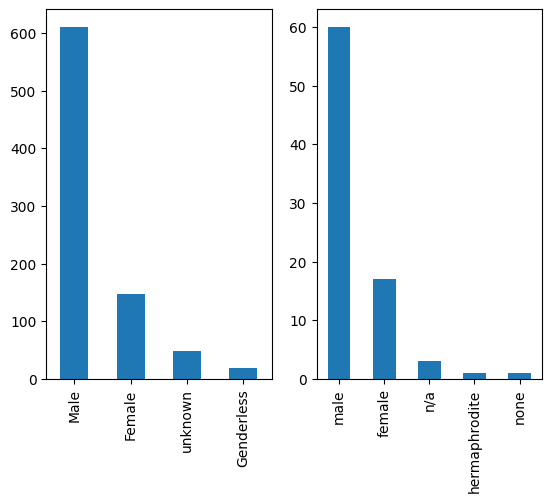

In [12]:
ax, fig = plt.subplots(1,2)
df_rm['gender'].value_counts().plot(kind='bar', ax = ax.get_axes()[0])
df_sw['gender'].value_counts().plot(kind='bar', ax = ax.get_axes()[1])

In [11]:
ax.get_axes()[0]

<AxesSubplot: >